## Instructions: ##
  
1) Place this file at the root of the folder you started jupyter notebook in.  
2) Create a "data/" folder containing all turnstile data you want to parse.  

_Example Structure:_  
~~~~
/MTA_data_parser.ipynb  
/data  
/data/turnstile_180922.txt
~~~~

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Put filepath here
fp = 'data/turnstile_180922.txt'
df = pd.read_csv(fp)

In [45]:
# Use to do preliminary inspection of data

def data_inspect(df, resampled=False):
    print("Summarize NAs:")
    print(df.isna().sum())
    
    u_station = df['STATION'].unique()
    print("\nNum Unique Stations:", len(u_station))
    print(u_station)
    
    u_desc = df['DESC'].unique()
    print("\n Unique Descriptions")
    print(u_desc)
    
    if resampled:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['DATETIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

    else:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['TIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

# data_inspect(df)

In [111]:
# Organize data before using diff() to find absolute diff in entries/exits.
# Zero out counter rollovers (discard)
# Aggregate times to ensure 4 hour interval in-between

def clean_data(df):
    stop_data = {}
    u_station = df['STATION'].unique()
    
    group_order = ['C/A', 'STATION', 'UNIT', 'SCP', 'DATE', 'TIME']
    # Sort by Control Area (station), Unit (Remote unit), SCP (turnstile), Date, Time
    df = df.sort_values(by=group_order)
    
    # Substract next row by prev row for magnitude of change
    df['DIFF_ENTRY'] = df['ENTRIES'].diff()
    df['DIFF_EXIT'] = df['ENTRIES'].diff()
    
    # Add datetime col to resample data
    df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    
    df.loc[df['DIFF_ENTRY'] < 0, 'DIFF_ENTRY'] = 0
    df.loc[df['DIFF_ENTRY'] > 4000, 'DIFF_ENTRY'] = 0
    
    for s in u_station:
        stop_data[s] = df[df['STATION'] == s][['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DIFF_EXIT', 'DATETIME']]
    
    pickle.dump(stop_data,open('stop_data', 'wb'))
    print('Done')
clean_data(df)

Done


59 ST
            DIFF_ENTRY
DATETIME              
2018-09-15     30933.0
2018-09-16     29742.0
2018-09-17     62172.0
2018-09-18     64318.0
2018-09-19     60185.0
2018-09-20     69404.0
2018-09-21     68863.0


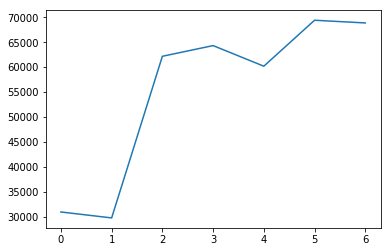

In [126]:
def plot_stop_data(fn):
    data = pickle.load(open(fn, 'rb'))
    for stop in data:
        stop_data = data[stop]
        stop_data = stop_data[['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DATETIME']]
        
        #resample
        grouped = stop_data.resample(rule='1D', on='DATETIME', base=0).sum()
        print(stop)
        print(grouped)
        amount  = list(grouped['DIFF_ENTRY'])
        plt.plot(amount)
        
        break
        
plot_stop_data('stop_data')

In [124]:
def first_last(df):
    turnstiles_df = df
    PREV_ENTRIES=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.first().reset_index()
    LAST=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.last().reset_index()
    PREV_ENTRIES['LAST']=LAST['ENTRIES']
    PREV_ENTRIES['DAILY']=PREV_ENTRIES['LAST']-PREV_ENTRIES['ENTRIES']
    ST59 = PREV_ENTRIES[PREV_ENTRIES['STATION'] == '59 ST']
    print(ST59.groupby(['DATE']).sum())
#     print(ST59[['C/A','UNIT','SCP','STATION','DATE','DAILY']])
    
first_last(df)

               ENTRIES        LAST  DAILY
DATE                                     
09/15/2018  4163504941  4163534550  29609
09/16/2018  4163540211  4163563019  22808
09/17/2018  4163566964  4163623043  56079
09/18/2018  4163630086  4163685233  55147
09/19/2018  4163692211  4163743383  51172
09/20/2018  4163750571  4163810459  59888
09/21/2018  4163818798  4163877180  58382
